In [65]:
# import required libraries
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import lime
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# display options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [66]:
# loading data
df_ = pd.read_csv('/Users/kevinbauer/Dropbox/Material AI lectures/Kevin/DataScienceLecture_Mannheim/DataTitanic.csv')
df_

survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male deck  embark_town alive  alone  
0      man        True  NaN  Southampton    no  False  
1    woman       False    C    Cherbourg   yes  False  
2    woman       False  NaN  Southampton   yes   True  
3    woman       False    C  Southampton   yes  False  
4      man        True  NaN  Southampton    no   True  
..     ...         ...  ...          ...   ...    ...  
886    man        True  NaN  Southampton    no   True  
887  woman       False    B  Southampton   yes   True  
888  woman       False  NaN  Southampton    no  False  
889    man        True    C    Cherbourg   yes   True  
890    man        True  NaN   Queenstown    no   True  

[891 rows x 15 columns]

In [70]:
# data preparation
df_prep = df_[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']].copy()
df_prep['age'] = df_prep['age'].fillna(df_prep['age'].mean())
df_prep.dropna(inplace=True, axis=0)

df_nonnum = df_prep.select_dtypes(include=['object'])
temp = pd.get_dummies(df_nonnum, prefix=['sex_', 'emb_'], drop_first=True).astype('int64')

df_final = pd.concat([df_prep.drop(['sex', 'embarked'], axis=1), temp], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df_final.drop(['survived'],axis=1), 
                                                        df_final['survived'], 
                                                        test_size=0.2, random_state=42)

## INTERPRETABLE MODEL: LOGIT

In [89]:
# logistic regression
search_space = {
        'C': [0.01, 0.1, 1, 10],       
        'penalty': ['l1', 'l2'],     
        'class_weight':['balanced'], 
        'solver': ['liblinear']
    }


opt = BayesSearchCV(
    estimator=LogisticRegression(max_iter=50, random_state=42),
    search_spaces=search_space,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    n_iter=15,
    verbose=0,
    refit=True,
    random_state=42
)

opt.fit(X_train, y_train)
model_logit = opt.best_estimator_

print(classification_report(y_test, model_logit.predict(X_test)))

d = pd.DataFrame(zip(X_train.columns, np.transpose(model_logit.coef_[0])), columns=['Variable', 'Coefficient'])
d

/Users/kevinbauer/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Users/kevinbauer/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Users/kevinbauer/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.

/Users/kevinbauer/opt/anaconda3/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning:

The objective has been evaluated at this point before.



BayesSearchCV(cv=5, estimator=LogisticRegression(max_iter=50, random_state=42),
              n_iter=15, n_jobs=-1, random_state=42, scoring='accuracy',
              search_spaces={'C': [0.01, 0.1, 1, 10],
                             'class_weight': ['balanced'],
                             'penalty': ['l1', 'l2'], 'solver': ['liblinear']})

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       109
           1       0.69      0.83      0.75        69

    accuracy                           0.79       178
   macro avg       0.78      0.79      0.78       178
weighted avg       0.80      0.79      0.79       178



Variable  Coefficient
0     pclass    -1.052163
1        age    -0.042795
2      sibsp    -0.389161
3      parch    -0.079746
4       fare     0.002622
5  sex__male    -2.651911
6     emb__Q    -0.148084
7     emb__S    -0.523297

## BLACKBOX MODEL: XGBOOST

In [71]:
# model training
search_space = {
    'learning_rate': [0.001, 0.01],
    'max_depth': [4,5,6],
    'subsample': [0.7,0.8],
    'colsample_bytree': [0.6, 0.7],
    'colsample_bylevel': [0.6, 0.7],
    'reg_alpha':  [0.1, 1, 10],
    'n_estimators': [200,300, 500]
        }

# bayesian optimization
opt = BayesSearchCV(
        estimator=xgb.XGBClassifier(
            n_jobs=-1,
            objective='binary:logistic',
            eval_metric='logloss',
            tree_method='approx',
            random_state=42
        ),
        search_spaces=search_space,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        n_iter=15,
        verbose=0,
        refit=True,
        random_state=42
    )

# fitting the model
opt.fit(X_train, y_train)
model = opt.best_estimator_

# testing the model
print(classification_report(y_test, model.predict(X_test)))

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric='logloss', feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate...
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=-1,
                                      num_parallel_tree=None, predictor=None,
             

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       109
           1       0.78      0.72      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



## EXPLANATION METHODS

### SHAP

In [72]:
shap.initjs()
explainer_xgb = shap.TreeExplainer(model,data = X_test,model_output='probability') #shap.Explainer(model.predict, X_test, model_output='probability')
shap_values_xgb = explainer_xgb(X_test)

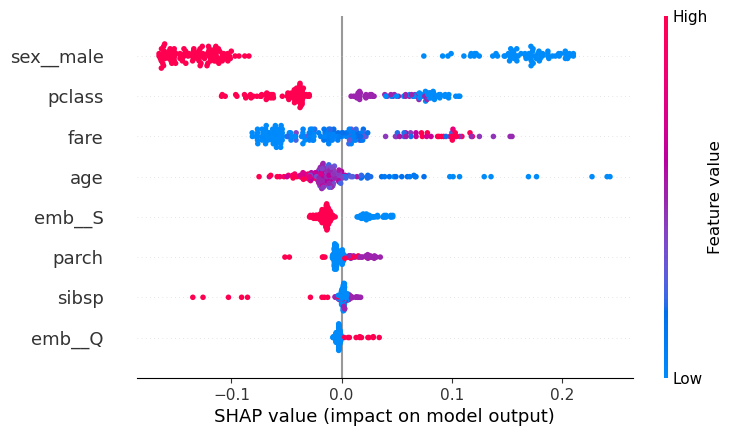

Model prediction for instance: 0.8363559246063232
Actual outcome: 1


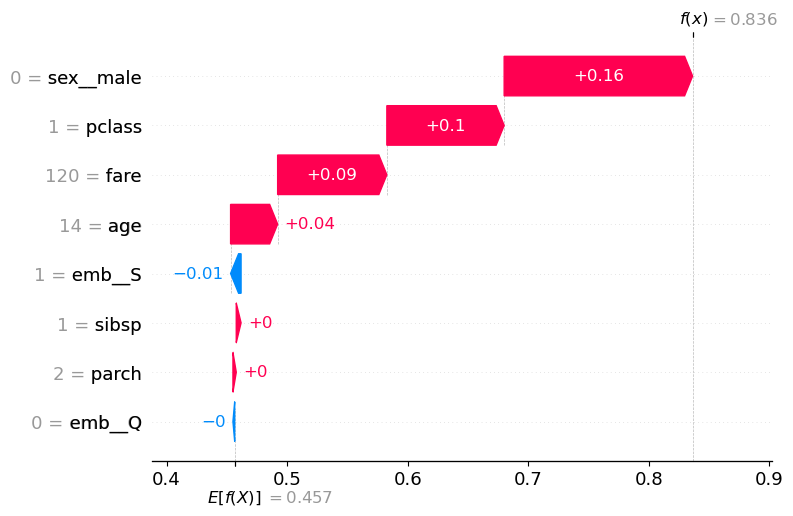

In [73]:
# global explanations
shap.plots.beeswarm(shap_values_xgb)

# local explanations
print(f'Model prediction for instance: {model.predict_proba(X_test)[:,1][1]}')
print(f'Actual outcome: {y_test.iloc[1]}')
shap.plots.waterfall(shap_values_xgb[1], max_display=14)

### LIME

In [74]:
import lime.lime_tabular

# Create a LIME explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                   mode='classification',
                                                   training_labels=y_train,
                                                   feature_names=X_train.columns,
                                                   class_names=['No Default', 'Default'],
                                                   discretize_continuous=True,
                                                   verbose=True)

# Explain the model's prediction
for i in [1]:
    # produce local explanation
    exp = explainer.explain_instance(
        X_test.iloc[i].values, 
        model.predict_proba, 
        num_features=5, 
        top_labels=1
    )

# print the explanation
exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.2490679265822912
Prediction_local [0.82272364]
Right: 0.8363559


## Counteractual explanations

In [95]:
import dice_ml

continous_col=['age','fare']
dice_data = dice_ml.Data(dataframe=df_final,
                         continuous_features=continous_col, 
                         outcome_name='survived',
                         enable_categorical=True)

dice_model= dice_ml.Model(model=model_logit, backend='sklearn')
explainer = dice_ml.Dice(dice_data,dice_model, method='random')

expls = explainer.generate_counterfactuals(X_test.iloc[[1]], 
                                           total_CFs=3, 
                                           desired_class='opposite',
                                          features_to_vary=['age', 'sex__male'])

expls.visualize_as_dataframe()

100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]

Query instance (original outcome : 1)


pclass   age sibsp parch   fare sex__male emb__Q emb__S  survived
0      1  14.0     1     2  120.0         0      0      1         1


Diverse Counterfactual set (new outcome: 0.0)


pclass        age  sibsp  parch   fare sex__male  emb__Q  emb__S  survived
0     1.0  56.089568    1.0    2.0  120.0         1     0.0     1.0         0
1     1.0  66.094275    1.0    2.0  120.0         1     0.0     1.0         0
2     1.0  70.984005    1.0    2.0  120.0         1     0.0     1.0         0

## WHITEBOX MODEL: EXPLAINABLE BOOSTING MACHINE

In [19]:
# training model
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# testing the model
print(classification_report(y_test, ebm.predict(X_test)))

ExplainableBoostingClassifier()

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       109
           1       0.74      0.77      0.75        69

    accuracy                           0.80       178
   macro avg       0.79      0.80      0.79       178
weighted avg       0.81      0.80      0.80       178



In [31]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
show(ebm.explain_global())

In [34]:
show(ebm.explain_local(X_test.iloc[[1]], y_test.iloc[[1]]), 0)